<a href="https://colab.research.google.com/github/fabianmax/car-classification/blob/master/notebooks/car_classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Select TF2.x as version
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import sys
import pprint
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

from importlib.machinery import SourceFileLoader

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import (Dense, 
                                     GlobalAveragePooling2D, 
                                     Flatten, 
                                     Conv2D, 
                                     MaxPool2D, 
                                     Input, 
                                     Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

In [0]:
# Mount Google Drive for data
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!git clone https://github.com/fabianmax/car-classification.git
!mkdir car-classification/data
!mkdir car-classification/data/raw
!cp drive/My\ Drive/Car-Classifier/data/zip/cars_filtered_top300.zip car-classification/data
!unzip -q car-classification/data/cars_filtered_top300.zip -d car-classification/data/raw

fatal: destination path 'car-classification' already exists and is not an empty directory.
mkdir: cannot create directory ‘car-classification/data’: File exists
mkdir: cannot create directory ‘car-classification/data/raw’: File exists
replace car-classification/data/raw/cars_filtered_top300/Ford_Flex_2010_39_19_260_35_6_75_68_201_16_AWD_7_4_4dr_Zza.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!ls drive/My\ Drive/

 Car-Classifier  'Colab Notebooks'


In [0]:
#ROOT = '/content/drive'
#PROJECT = 'My Drive/Car-Classifier'
#PROJECT_PATH = os.path.join(ROOT, PROJECT)
PROJECT_PATH = 'car-classification'
print(f'Project directory is {PROJECT_PATH}')
ACCELERATOR = 'GPU'

# Set working dir
os.chdir(PROJECT_PATH)

Project directory is car-classification


In [0]:
# Pull latest files from github
!git pull

sys.path.append(os.getcwd())

# Sources python files from Google Drive
car_classifier_pipeline = SourceFileLoader('car_classifier', 
                                           'car_classifier/pipeline.py').load_module()

car_classifier_model = SourceFileLoader('car_classifier', 
                                        'car_classifier/modeling.py').load_module()

car_classifier_utils = SourceFileLoader('car_classifier', 
                                        'car_classifier/utils.py').load_module()                                     

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/fabianmax/car-classification
   ed169db..66a8f0c  master     -> origin/master
Updating ed169db..66a8f0c
Fast-forward
 car_classifier/modeling.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [0]:
def test_files():
  """
  Test if all files present 
  """
  files = os.listdir(INPUT_DATA_DIR)
  assert len(files) == 53536, f'Found {len(files)} but expected 53536 files.'

def test_tpu():
  """
  Test if TPU usage is possible
  """
  if 'COLAB_TPU_ADDR' not in os.environ:
    print('ERROR: Not connected to a TPU runtime; \
    please see the first cell in this notebook for instructions!')
  else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    print ('TPU address is', tpu_address)

  with tf.compat.v1.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

def test_gpu():
  """
  Test if GPU usage is possible
  """
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

In [0]:
# Gobal settings
INPUT_DATA_DIR = 'data/raw/cars_filtered_top300/'
MODEL_DIR = '/content/drive/My Drive/Car-Classifier/models/'
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
TARGET = 'model'
BASE = 'ResNet'

In [0]:
# Test files
test_files()

# Test GPU/TPU
if ACCELERATOR == 'TPU':
  test_tpu()
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
elif ACCELERATOR == 'GPU':
  test_gpu()

Found GPU at: /device:GPU:0


In [0]:
# All available training images
files = [file for file in os.listdir(INPUT_DATA_DIR) if file.endswith(".jpg")]

file_paths = [INPUT_DATA_DIR + file for file in files]

# Create a list of all possible outcomes
if TARGET == 'make':
    classes = list(set([file.split('_')[0] for file in files]))
if TARGET == 'model':
    classes = list(set([file.split('_')[0] + '_' + file.split('_')[1] for file in files]))

classes_lower = [x.lower() for x in classes]

# Split paths into train, valid, and test
files_train, files_test = train_test_split(file_paths, test_size=0.25)
files_train, files_valid = train_test_split(files_train, test_size=0.25)

# Construct tf.data.Dataset from file paths
ds_train = car_classifier_utils.construct_ds(input_files=files_train, 
                                                batch_size=BATCH_SIZE, 
                                                classes=classes_lower, 
                                                input_size=INPUT_SHAPE, 
                                                prefetch_size=BATCH_SIZE*10,
                                                augment=True,
                                                label_type=TARGET)

ds_valid = car_classifier_utils.construct_ds(input_files=files_valid, 
                                                batch_size=BATCH_SIZE, 
                                                classes=classes_lower, 
                                                input_size=INPUT_SHAPE, 
                                                prefetch_size=BATCH_SIZE*10,
                                                augment=False,
                                                shuffle=False,
                                                label_type=TARGET)

ds_test = car_classifier_utils.construct_ds(input_files=files_test, 
                                               batch_size=BATCH_SIZE, 
                                               classes=classes_lower, 
                                               input_size=INPUT_SHAPE, 
                                               prefetch_size=BATCH_SIZE*10,
                                               augment=False,
                                               shuffle=False,
                                               label_type=TARGET)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

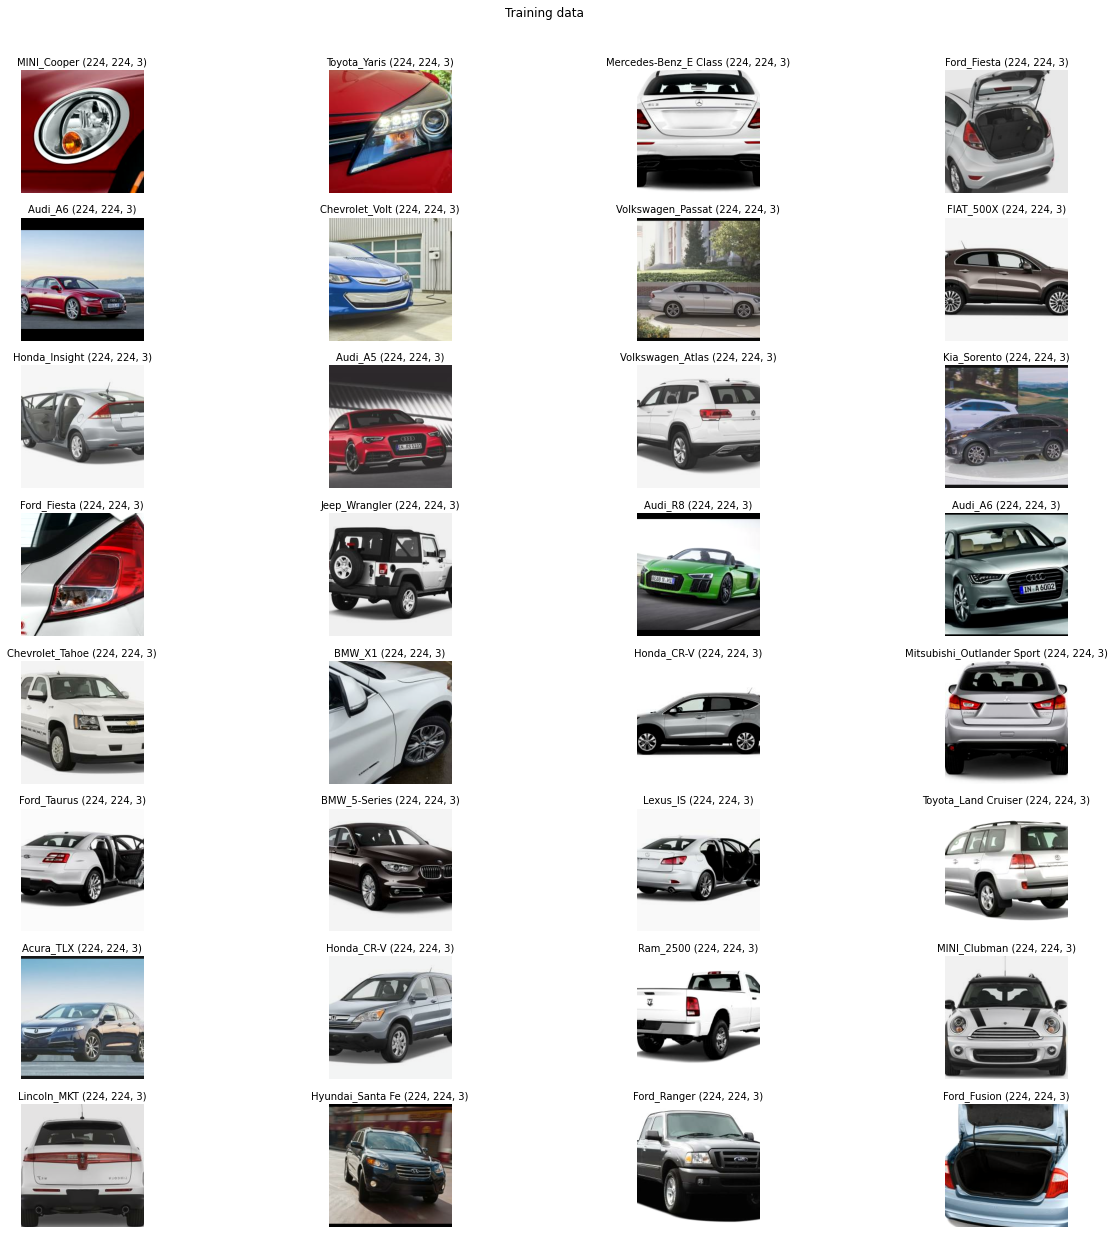

In [0]:
# Show examples from one batch
plot_size = (18, 18)

car_classifier_utils.show_batch(ds_train, classes, size=plot_size, title='Training data')
# car_classifier_utils.show_batch(ds_valid, classes, size=plot_size, title='Validation data')
# car_classifier_utils.show_batch(ds_test, classes, size=plot_size, title='Testing data')

In [0]:
# Overview over class distribution after splitting
def get_class_counts(files):
  """
  Get class label count from file paths
  """
  return pd.Series([file.split('/')[3].split('_')[0] + '_' + file.split('/')[3].split('_')[1] for file in files]).value_counts()

class_counts_train = get_class_counts(files_train)
class_counts_valid = get_class_counts(files_valid)
class_counts_test = get_class_counts(files_test)

class_distribution = pd.concat([class_counts_train.rename('train'), 
                                class_counts_valid.rename('valid'), 
                                class_counts_test.rename('test')], 
                               axis=1,
                               sort=False)

print(class_distribution[290:])

                   train  valid  test
Volkswagen_e-Golf     17      3    11
Hyundai_Venue         16      4     7
BMW_X7                16      2    10
Mazda_CX-30           16      7     6
Toyota_86             15      5     7
Genesis_G80           15      8     6
Cadillac_XT4          15      4     7
INFINITI_QX30         14     10    10
Kia_Soul EV           14      8     7
Nissan_Kicks          11      6     7


In [0]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes, pd.Series([file.split('_')[0] + "_" + file.split('_')[1] for file in files]))

Train for 942 steps, validate for 314 steps
Epoch 1/30
942/942 [==============================] - 168s 178ms/step - loss: 4.1194 - categorical_accuracy: 0.2070 - val_loss: 2.8367 - val_categorical_accuracy: 0.3813
Epoch 2/30
942/942 [==============================] - 161s 171ms/step - loss: 2.0929 - categorical_accuracy: 0.5581 - val_loss: 2.0034 - val_categorical_accuracy: 0.5638
Epoch 3/30
942/942 [==============================] - 161s 171ms/step - loss: 1.1584 - categorical_accuracy: 0.7532 - val_loss: 1.6902 - val_categorical_accuracy: 0.6392
Epoch 4/30
942/942 [==============================] - 161s 171ms/step - loss: 0.6571 - categorical_accuracy: 0.8632 - val_loss: 1.6530 - val_categorical_accuracy: 0.6513
Epoch 5/30
942/942 [==============================] - 161s 171ms/step - loss: 0.3888 - categorical_accuracy: 0.9224 - val_loss: 1.5829 - val_categorical_accuracy: 0.6883
Epoch 6/30
942/942 [==============================] - 161s 171ms/step - loss: 0.2371 - categorical_accurac

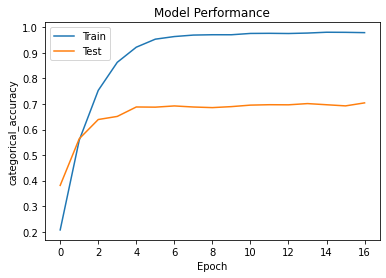

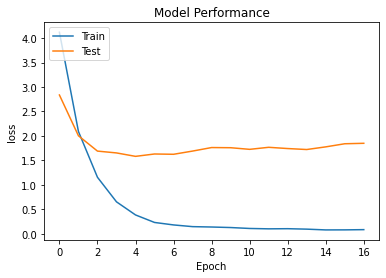

419/419 [==============================] - 26s 63ms/step - loss: 1.5539 - categorical_accuracy: 0.6884


{'categorical_accuracy': 0.68843395, 'loss': 1.553941886009635}

In [0]:
# Initialize base model and compile
model = car_classifier_model.TransferModel(base=BASE, shape=INPUT_SHAPE, classes=classes, unfreeze='all')
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(0.0001),
              metrics=["categorical_accuracy"])

# Train model
model.train(ds_train, epochs=30, ds_valid=ds_valid, class_weights=class_weights)

# Plot loss/accuracy on training and validation data sets
model.plot(what='metric')
model.plot(what='loss')

# Evaluate performance on testing data
model.evaluate(ds_test=ds_test)

In [0]:
MODEL_NAME = "final_unfreeze_all_model_v3"

In [0]:
model.save(MODEL_DIR + MODEL_NAME)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Car-Classifier/models/final_unfreeze_all_model_v3/model/assets


In [0]:
# Test restoring model
del model

model = car_classifier_model.TransferModel(base=BASE, shape=INPUT_SHAPE, classes=classes, unfreeze='all')

model.load(MODEL_DIR + MODEL_NAME)

print(model.model.summary())

model.evaluate(ds_test=ds_test)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

{'categorical_accuracy': 0.68843395, 'loss': 1.5535564015048215}

In [0]:
labels = []
predictions = []

for image, label in ds_valid:
  predictions.append(model.predict(image))
  labels.append(label)


In [0]:
labels = np.concatenate(labels)
predictions = np.concatenate(predictions)

In [0]:
labels_idx = np.argmax(labels, axis=1)

In [0]:
predictions_idx = np.argmax(predictions, axis=1)

In [0]:
cfm = tf.math.confusion_matrix(labels_idx, predictions_idx)

In [0]:
cfm

<tf.Tensor: shape=(300, 300), dtype=int32, numpy=
array([[31,  0,  0, ...,  0,  0,  0],
       [ 0, 11,  0, ...,  0,  0,  0],
       [ 0,  0, 27, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  4,  0,  0],
       [ 0,  0,  0, ...,  0, 15,  1],
       [ 0,  0,  0, ...,  0,  0, 48]], dtype=int32)>

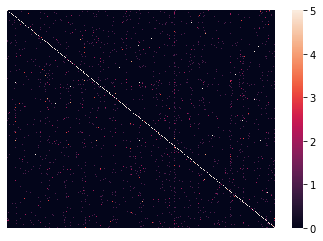

In [0]:
import seaborn as sns
cfm_plot = sns.heatmap(cfm, vmin=0, vmax=5, xticklabels=False, yticklabels=False)

In [0]:
fig = cfm_plot.get_figure()
fig.savefig("/content/drive/My Drive/Car-Classifier/data/heatmap_v3.png", dpi=200)